In [1]:
from dotenv import load_dotenv
import os

import pandas as pd
import numpy as np
import math
from itertools import cycle
import statistics
import shap


#from datetime import datetime
import datetime

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

from scipy.stats import randint, shapiro, uniform
#from scipy.stats import uniform as sp_randFloat
#from scipy.stats import randint as sp_randInt

import scikitplot as skplt
import sklearn as sk
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as ltb
import xgboost as xgb

import statsmodels.api as sm
import statsmodels
from statsmodels.tools import eval_measures

from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from fredapi import Fred
import pandas_datareader as pdr

import warnings

In [2]:
sk.set_config(display='diagram')
warnings.filterwarnings("ignore")
shap.initjs()

# Plotting using Seaborn
sns.set(style="whitegrid")
style.use("seaborn-white")

In [3]:
#  Federal Reserve Economic Data Service
load_dotenv()

fred_api_key = os.getenv("fred_api_key")
fred = Fred(api_key=fred_api_key)

In [4]:
from common.load_features import get_recession, add_recession_feature, get_fed_chair, add_fed_chair
from common.load_data import load_taylor,load_misery, time_split
from common.calc_metrics import model_results
from common.LinearRegDiagnostic import LinearRegDiagnostic

# Setup

## variables

In [5]:
rand_int = 12

#  Set start date
start_date = datetime.date(1940, 1, 1)
start_date_str = datetime.datetime.strftime(start_date, "%Y-%m-%d")

# Functions

In [6]:
t0_df = load_taylor()
train0_df, test0_df = time_split(t0_df)

model_stats_df = model_results('ffef_tr_train', train0_df['FEDFUNDS'], train0_df['ffef_tr'], 0, None)
model_stats_df = model_results('ffef_tr_test', test0_df['FEDFUNDS'], test0_df['ffef_tr'], 0, model_stats_df)
                              
model_stats_df = model_results('ffef_tr2_train', train0_df['FEDFUNDS'], train0_df['ffef_tr2'], 0, model_stats_df )
model_stats_df = model_results('ffef_tr2_test', test0_df['FEDFUNDS'], test0_df['ffef_tr2'], 0, model_stats_df )                         

model_stats_df

t1_df: (1007, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
cpi_df: (909, 2)
holston_df: (250, 4)
ff_cpi_df: (832, 2)
train_df:  (197, 25)
test_df:  (49, 25)


,name,mse,rmse,mape,mae,aic
0,ffef_tr_train,25.4002,5.0399,2.1100,4.4310,0
1,ffef_tr_test,57.2779,7.5682,41.6492,6.8936,0
2,ffef_tr2_train,1.1202,1.0584,0.2525,0.6816,0
3,ffef_tr2_test,0.3307,0.5750,3.4681,0.4071,0


# Load Data

In [7]:
taylor_df = load_taylor()
train_df, test_df = time_split(taylor_df)

t1_df: (1007, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
cpi_df: (909, 2)
holston_df: (250, 4)
ff_cpi_df: (832, 2)
train_df:  (197, 25)
test_df:  (49, 25)


In [8]:
taylor_df['chair_name'].unique()

array(['Martin', 'Burns', 'Miller', 'Volcker', 'Greenspan', 'Bernanke',
       'Yellen', 'Powell'], dtype=object)

In [9]:
X_train = train_df[['FEDFUNDS-1','gap_inf', 'gap_ue']]
y_train = train_df['FEDFUNDS']


X_test = test_df[['FEDFUNDS-1','gap_inf', 'gap_ue']]
y_test = test_df['FEDFUNDS']

In [10]:
# Initialize Imputer
imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
num_columns_lst = ['FEDFUNDS-1','gap_inf', 'gap_ue']
numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_columns_lst),
    ]
)

In [11]:
t_fit = preprocessor.fit(X_train)
t_fit.get_feature_names_out()
X_train_trf = t_fit.transform(X_train)

#X_train_trf.columns = 
X_train_trf = pd.DataFrame(X_train_trf)
X_train_trf.columns = t_fit.get_feature_names_out()
X_train_trf['DATE'] = y_train.index
X_train_trf.set_index('DATE', inplace=True)

print('X_train_trf: ', X_train_trf.shape)

X_train_trf:  (197, 3)


In [12]:
X_test_trf = t_fit.transform(X_test)

X_test_trf = pd.DataFrame(X_test_trf)
X_test_trf.columns = t_fit.get_feature_names_out()
X_test_trf['DATE'] = y_test.index
X_test_trf.set_index('DATE', inplace=True)

print('X_test_trf: ', X_test_trf.shape)

X_test_trf:  (49, 3)


In [13]:
X_test_trf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49 entries, 2011-06-30 to 2023-06-30
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   num__FEDFUNDS-1  49 non-null     float64
 1   num__gap_inf     49 non-null     float64
 2   num__gap_ue      49 non-null     float64
dtypes: float64(3)
memory usage: 1.5 KB


# Stats Model - Taylor Index

In [14]:
X_train_const = sm.add_constant(X_train_trf)

In [15]:
ols_model = sm.OLS(y_train, X_train_const)
ols_result = ols_model.fit()

ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               FEDFUNDS   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     828.9
Date:                Sun, 31 Dec 2023   Prob (F-statistic):          5.96e-110
Time:                        18:31:42   Log-Likelihood:                -262.71
No. Observations:                 197   AIC:                             533.4
Df Residuals:                     193   BIC:                             546.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.4416      0.144      3.059      0.003       0.157       0.726
num__FEDFUNDS-1     0.9028      0.029     31.123      0.000       0.846       0.960
num__gap_inf        0.1102      0.034      3.234      0.001       0.043       0.177
num__gap_ue        -0.1215      0.042     -2.908      0.004      -0.204      -0.039
==============================================================================
Omnibus:                       48.937   Durbin-Watson:                   1.533
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              604.436
Skew:                           0.439   Prob(JB):                    5.60e-132
Kurtosis:                      11.536   Cond. No.                         16.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
train_pred = ols_result.predict(X_train_const)

t = ols_result.get_prediction(X_train_const)
train_pred_ols = t.summary_frame(alpha=0.05)

In [17]:
#model_stats_df = model_results('ols_train', y_train, train_pred_ols['mean'], X_train.shape[0], X_train.shape[1] , model_stats_df )
#$model_stats_df = model_results('ols_train',y_train, train_pred_ols['mean'], ols_model.aic, model_stats_df )
#model_stats_df = model_results('SARIMAX_test', y_test, test_pred_SARIM['mean'], 0, model_stats_df )

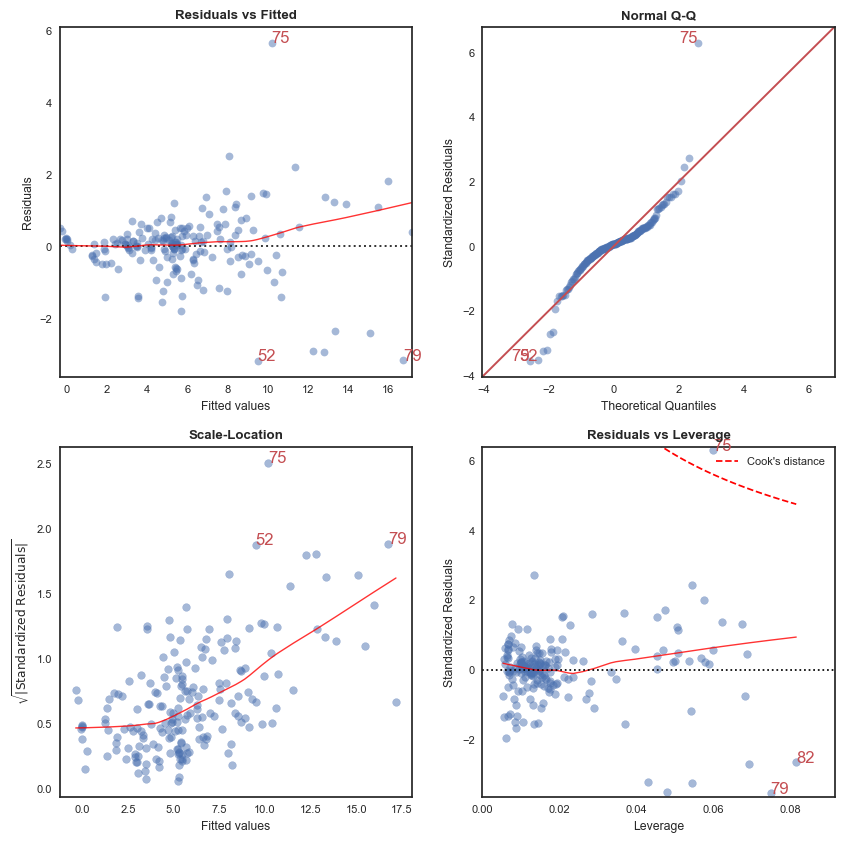

          Features  VIF Factor
0            const    4.772192
1  num__FEDFUNDS-1    2.234652
2     num__gap_inf    2.231081
3      num__gap_ue    1.023581


In [18]:
cls = LinearRegDiagnostic(ols_result)
vif, fig, ax = cls()
print(vif)

In [19]:
# Get the residuals from the fitted model
residuals = ols_result.resid

# Perform Shapiro-Wilk test for normality
shapiro_test = shapiro(residuals)

# Display the Shapiro-Wilk test statistic and p-value
print("Shapiro-Wilk Test Statistic:", shapiro_test.statistic)
print("Shapiro-Wilk p-value:", round(shapiro_test.pvalue,6))

Shapiro-Wilk Test Statistic: 0.8651490211486816
Shapiro-Wilk p-value: 0.0


## Test

In [20]:
X_test_trf = t_fit.transform(X_test)

X_test_trf = pd.DataFrame(X_test_trf)
X_test_trf.columns = t_fit.get_feature_names_out()
X_test_trf['DATE'] = y_test.index
X_test_trf.set_index('DATE', inplace=True)

X_test_const = sm.add_constant(X_test_trf)
print('X_test_const: ', X_test_const.shape)

X_test_const:  (49, 4)


In [21]:
t = ols_result.get_prediction(X_test_const)
test_pred_ols = t.summary_frame(alpha=0.05)
test_pred_ols.shape

(49, 6)

In [22]:
#model_stats_df = model_results('ols_test', y_test, test_pred_ols['mean'], X_test.shape[0], X_test.shape[1] , model_stats_df )

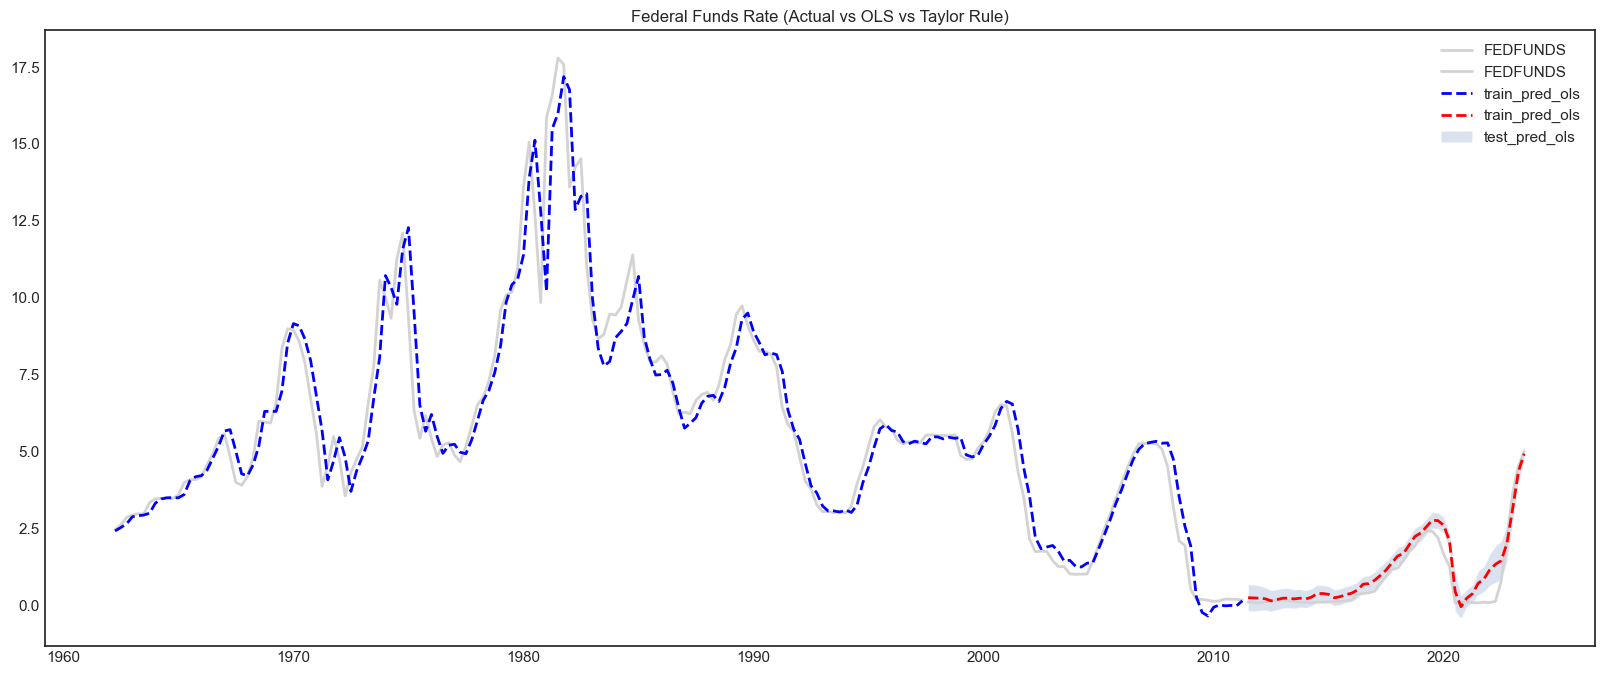

In [23]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(train_pred_ols.index, train_pred_ols['mean'], color='blue', linestyle='--', linewidth=2)
ax.plot(test_pred_ols.index, test_pred_ols['mean'], color='red', linestyle='--', linewidth=2)
ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_ols","train_pred_ols",'test_pred_ols',"ffef_tr"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');
plt.show()

# Lasso

In [24]:
# Lasso with 5 fold cross-validation
lasso_cv_model = LassoCV(cv=5, random_state=rand_int, max_iter=10000)

# Fit model
lasso_cv_model.fit(X_train_trf, y_train)

print('model.alpha_: ', lasso_cv_model.alpha_)

model.alpha_:  0.01118420293975338


In [25]:
lasso_best = Lasso(alpha=lasso_cv_model.alpha_)
lasso_best.fit(X_train_trf, y_train)

train_pred_lasso = lasso_best.predict(X_train_trf)

In [26]:
feature_df = pd.DataFrame(lasso_best.coef_, t_fit.get_feature_names_out())
feature_df.columns = ['coef']
feature_df

,coef
num__FEDFUNDS-1,0.902403
num__gap_inf,0.108829
num__gap_ue,-0.116666


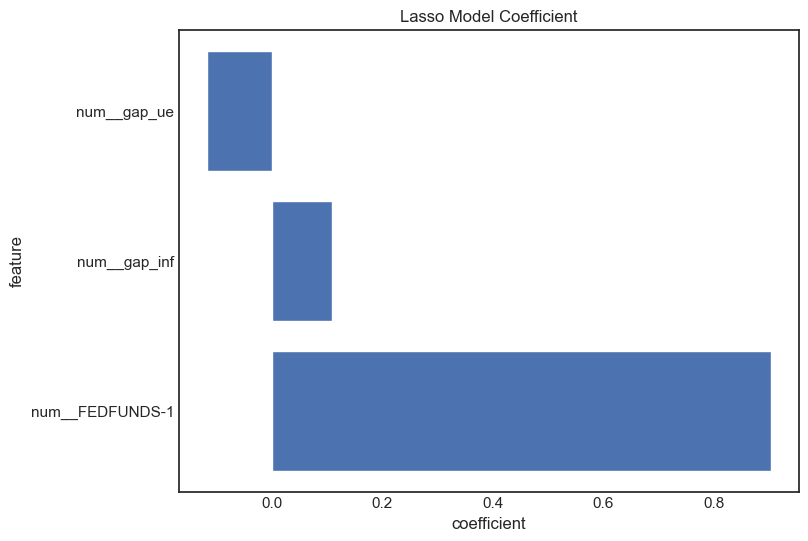

In [27]:
# Plot the MSE values against alphas
plt.figure(figsize=(8, 6))
plt.barh(feature_df.index, feature_df['coef'])

#plt.legend()
plt.xlabel('coefficient')
plt.ylabel('feature')
plt.title('Lasso Model Coefficient')
plt.grid(False)
plt.show()

In [28]:
#model_stats_df = model_results('lasso_train', y_train, train_pred_lasso, X_train.shape[0], X_train.shape[1] , model_stats_df )

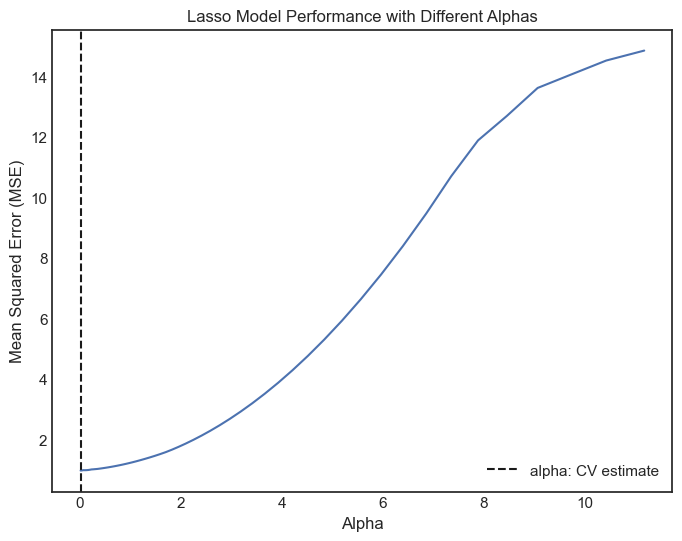

In [29]:
mse_values = np.mean(lasso_cv_model.mse_path_, axis=1)

# Plot the MSE values against alphas
plt.figure(figsize=(8, 6))
plt.plot(lasso_cv_model.alphas_, mse_values)

plt.axvline(
    lasso_cv_model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Lasso Model Performance with Different Alphas')
plt.grid(False)
plt.show()

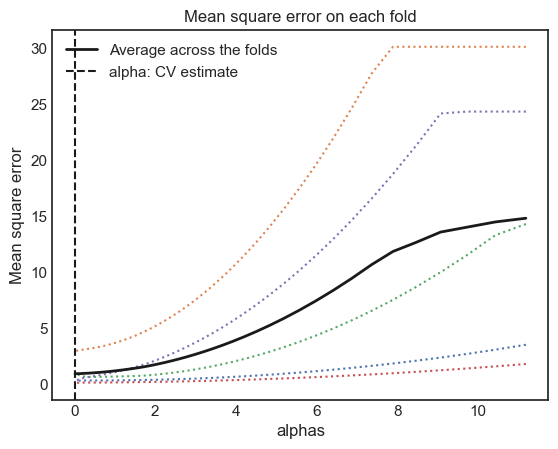

In [30]:
#plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(lasso_cv_model.alphas_, lasso_cv_model.mse_path_, ":")
plt.plot(
    lasso_cv_model.alphas_ ,
    lasso_cv_model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    lasso_cv_model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

plt.show()

#ymin, ymax = 50000, 250000
#plt.ylim(ymin, ymax);

In [31]:
test_pred_lasso = lasso_best.predict(X_test_trf)
print('test_pred_lasso: ', test_pred_lasso.shape)

test_pred_lasso:  (49,)


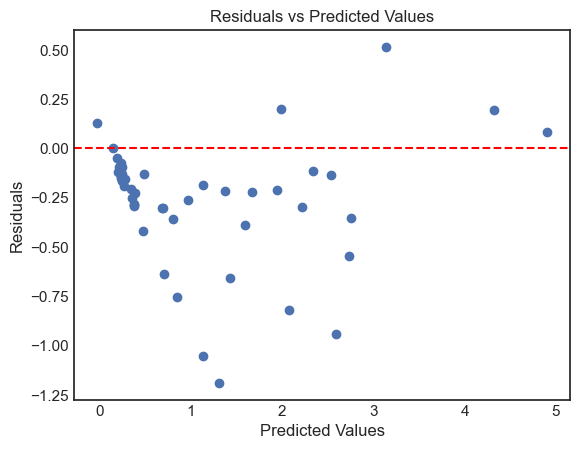

In [32]:
residuals = y_test - test_pred_lasso

plt.scatter(test_pred_lasso, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='red', linestyle='--')  # Add horizontal line at y=0 for reference
plt.show()

In [33]:
#model_stats_df = model_results('lasso_test', y_test, test_pred_lasso, X_test.shape[0], X_test.shape[1] , model_stats_df )

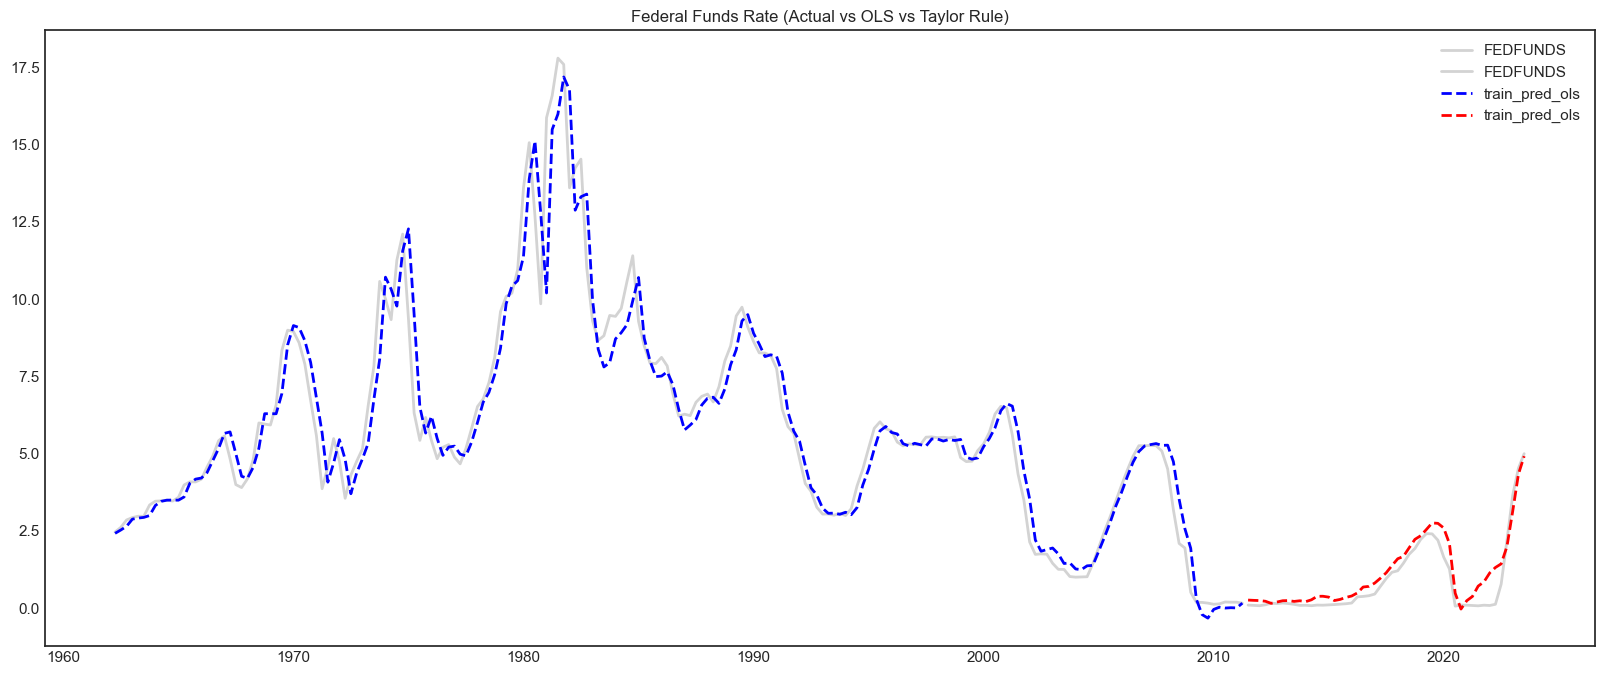

In [34]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(train_pred_ols.index, train_pred_lasso, color='blue', linestyle='--', linewidth=2)
ax.plot(test_pred_ols.index, test_pred_lasso, color='red', linestyle='--', linewidth=2)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_ols","train_pred_ols",'test_pred_ols',"ffef_tr"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');

plt.show()

## Shap

In [35]:
model = lasso_cv_model

In [36]:
explainer = None
shap_values = None

try:
    explainer = shap.Explainer(model, X_train_trf)
    shap_values = explainer(X_train_trf)
except Exception as e:
    print('-- error ')
    print(e)

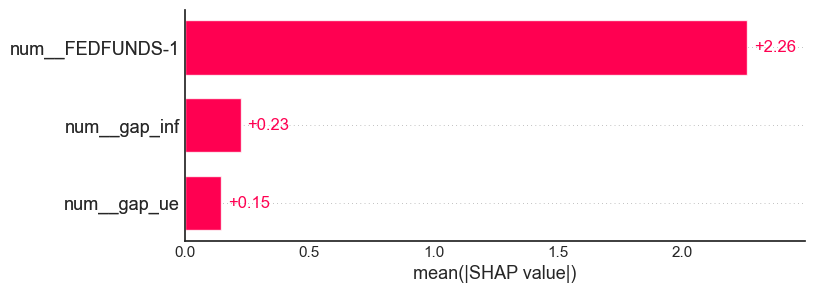

In [37]:
if (shap_values is not None):
    shap.plots.bar(shap_values, max_display=20)

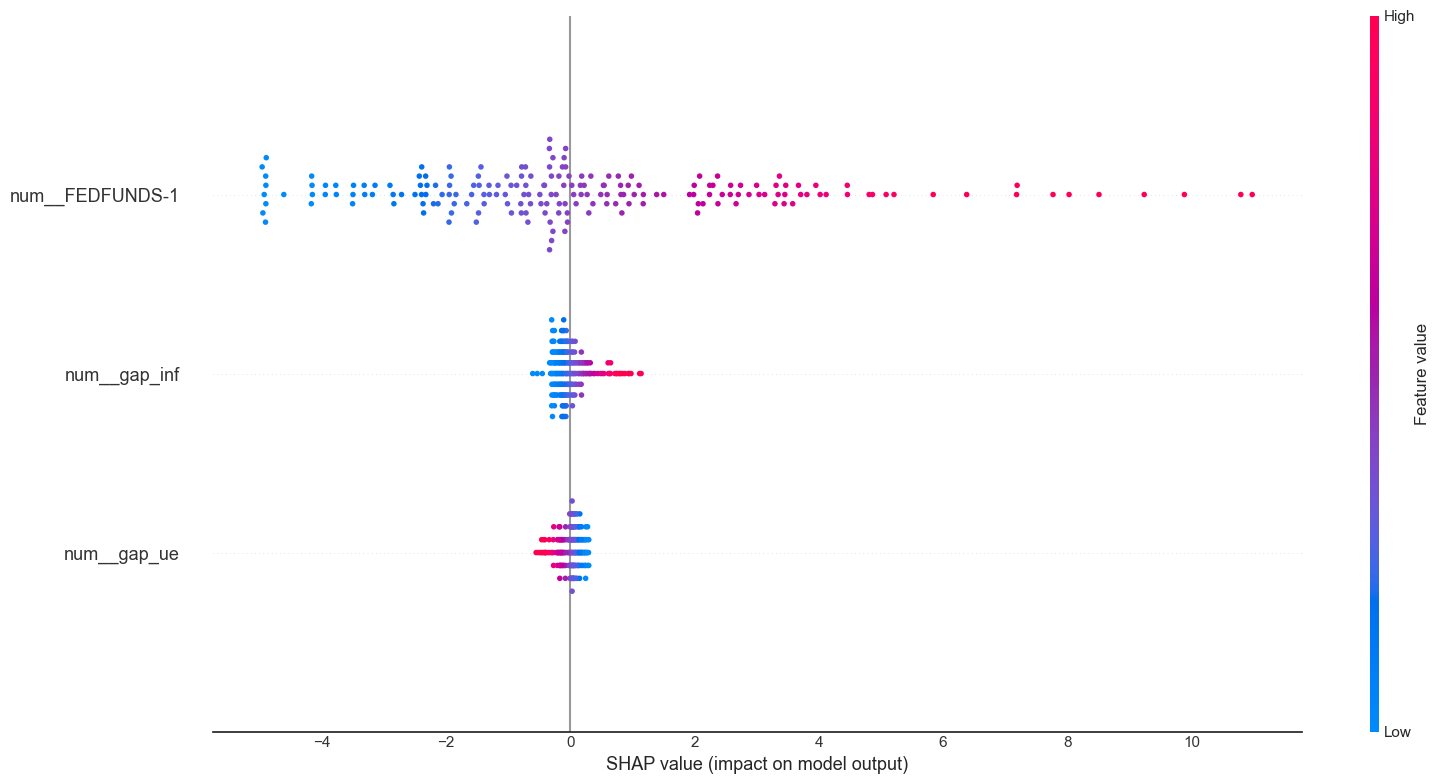

In [38]:
if (shap_values is not None):
    shap.summary_plot(shap_values, X_train_trf, plot_size=(16,8))

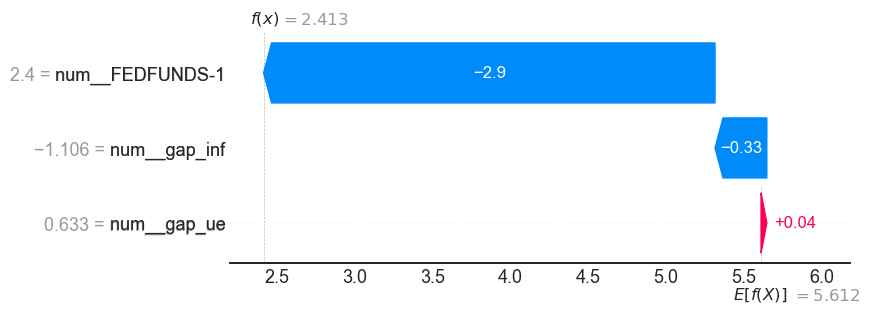

In [39]:
if (shap_values is not None):
    shap.plots.waterfall(shap_values[0], max_display=20)

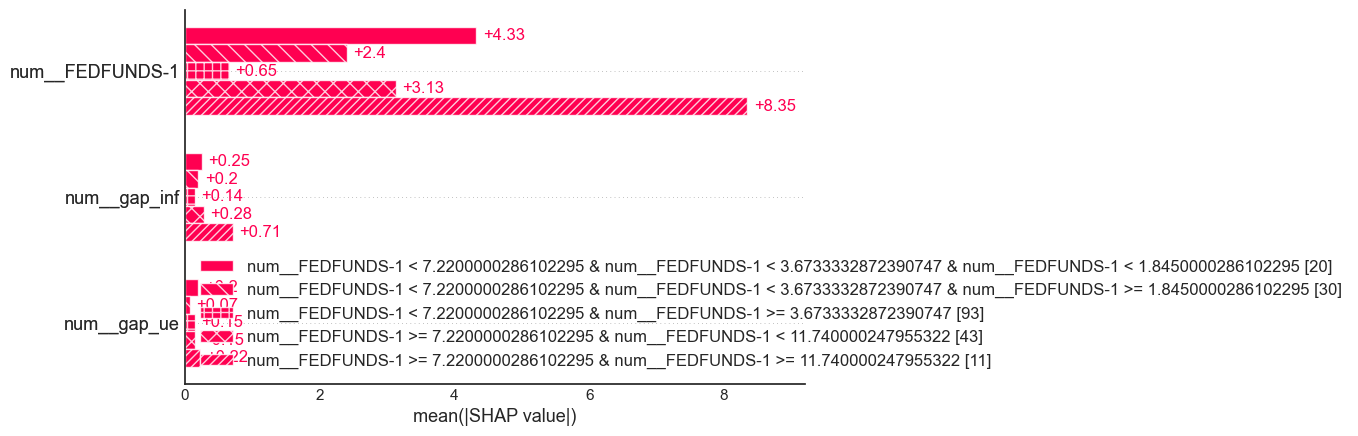

In [40]:
if (shap_values is not None):
    shap.plots.bar(shap_values.cohorts(5).abs.mean(0),  max_display=10)

## Shap Test

In [41]:
lainer = None
shap_values = None

try:
    explainer = shap.Explainer(model, X_test_trf)
    shap_values = explainer(X_test_trf)
except Exception as e:
    print('-- error ')
    print(e)

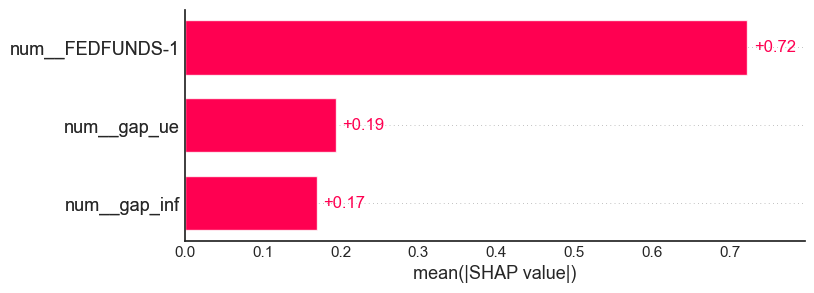

In [42]:
if (shap_values is not None):
    shap.plots.bar(shap_values, max_display=20)

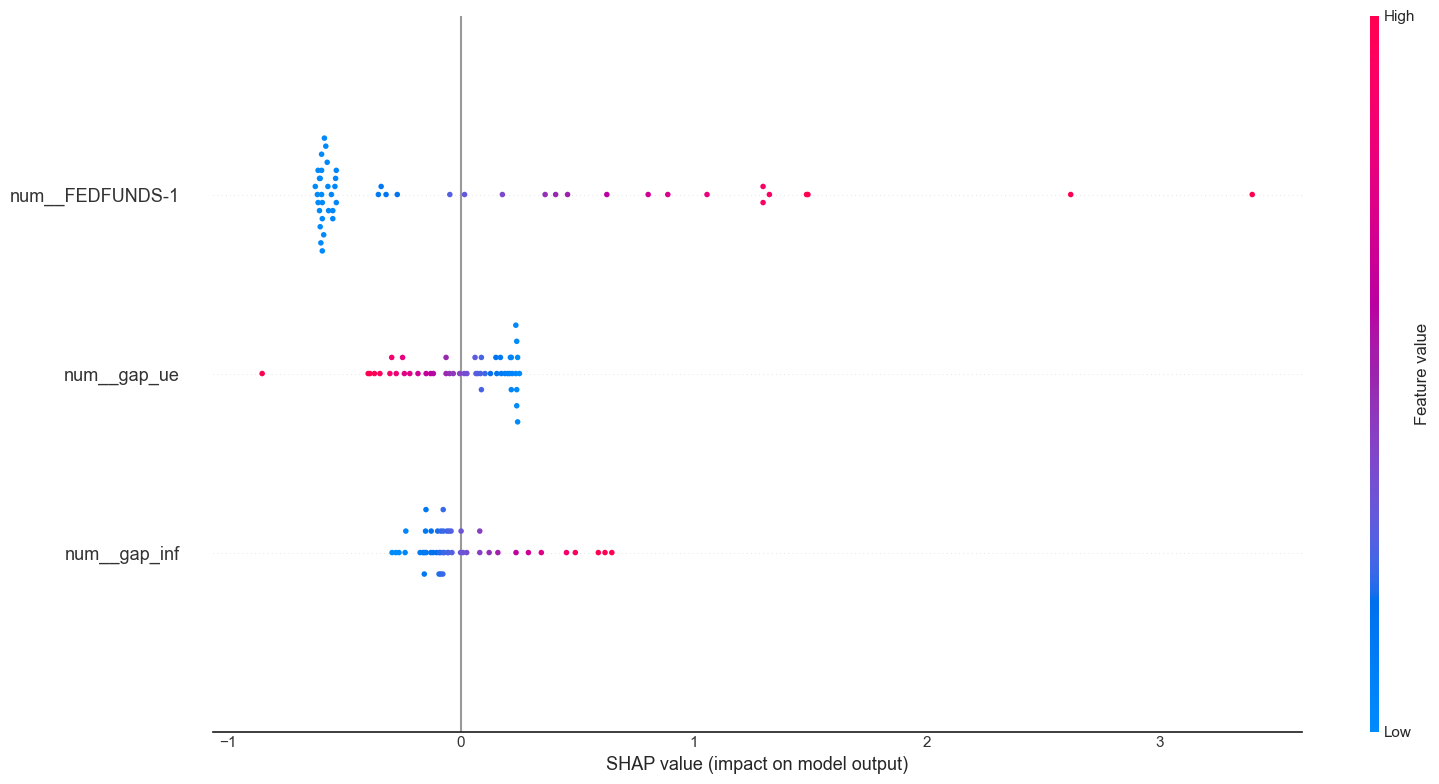

In [43]:
if (shap_values is not None):
    shap.summary_plot(shap_values, X_test_trf, plot_size=(16,8))

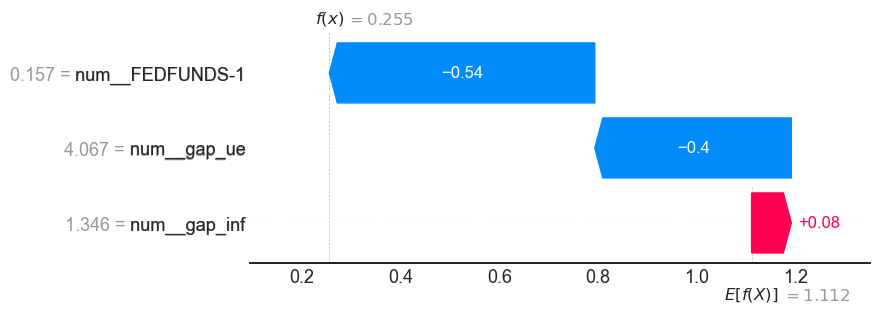

In [44]:
if (shap_values is not None):
    shap.plots.waterfall(shap_values[0], max_display=20)

if (shap_values is not None):
    cc = ["Registered" if shap_values[i,"cat__onehotencoder__cc_indicator_0"].data == 0 else "Not Registered" for i in range(shap_values.shape[0])]
    shap.plots.bar(shap_values.cohorts(cc).abs.mean(0), max_display=20)

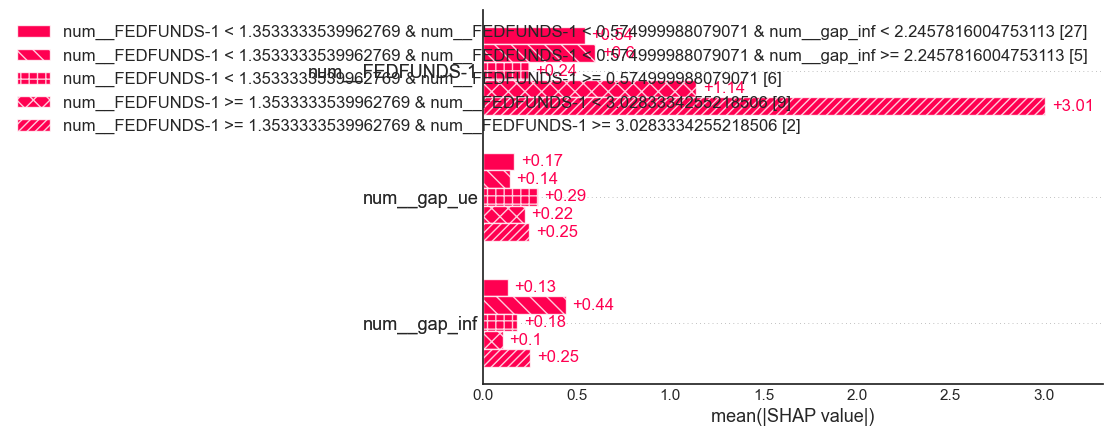

In [45]:
if (shap_values is not None):
    shap.plots.bar(shap_values.cohorts(5).abs.mean(0),  max_display=10)

In [46]:
explainer_tmp = None
shap_values_tmp = None

In [47]:
try:
    explainer_tmp = shap.Explainer(model)
    shap_values_tmp = explainer_tmp.shap_values(X_test_trf)
except Exception as e:
    print('-- error ')
    print(e)

-- error 
The passed model is not callable and cannot be analyzed directly with the given masker! Model: LassoCV(cv=5, max_iter=10000, random_state=12)


In [48]:
if (shap_values_tmp is not None):
    expected_value = explainer.expected_value
    shap.decision_plot(expected_value, shap_values_tmp[0][:20], feature_names, ignore_warnings=True)

if (shap_values is not None):
    shap.plots.scatter(shap_values[:,"num__NumberOfLocations"])

In [49]:
shap.force_plot(shap_values[0], plot_cmap = "PkYg")

# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(X)

# make a standard partial dependence plot
sample_ind = 20
shap.partial_dependence_plot(
    "FEDFUNDS",
    model.predict,
    X100,
    model_expected_value=True,
    feature_expected_value=True,
    ice=False,
    shap_values=shap_values[sample_ind : sample_ind + 1, :],
)

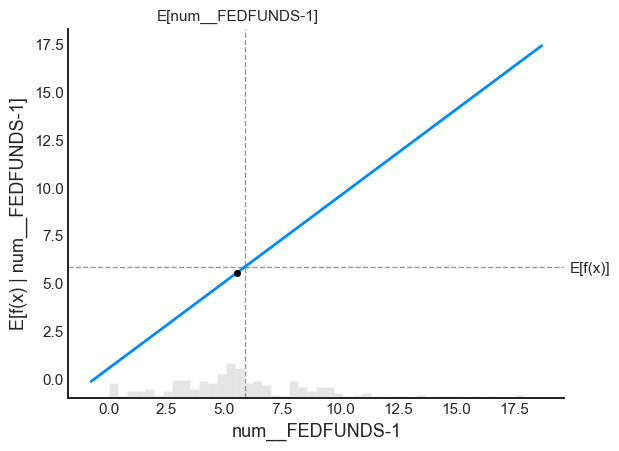

In [50]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, X_train_trf)
shap_values = explainer(X_train_trf)

# make a standard partial dependence plot
sample_ind = 20
shap.partial_dependence_plot(
    "num__FEDFUNDS-1",
    model.predict,
    X_train_trf,
    model_expected_value=True,
    feature_expected_value=True,
    ice=False,
    shap_values=shap_values[sample_ind : sample_ind + 1, :],
)

In [51]:
X_train_trf

,num__FEDFUNDS-1,num__gap_inf,num__gap_ue
DATE,,,
1962-03-31,2.400000,-1.106343,0.633333
1962-06-30,2.456667,-0.692580,0.533333
1962-09-30,2.606667,-0.798027,0.566667
1962-12-31,2.846667,-0.699547,0.533333
1963-03-31,2.923333,-0.770887,0.766667
...,...,...,...
2010-03-31,0.120000,0.352873,4.833333
2010-06-30,0.133333,-0.222707,4.633333
2010-09-30,0.193333,-0.796910,4.466667


# LGBM

In [52]:
pipe_ltb = Pipeline(
    steps = [ ('preprocessor',preprocessor), ('model',ltb.LGBMRegressor())]
)

param_ltb = {
    'model__n_estimators': randint(100, 300), #[100, 200, 300],
    'model__learning_rate': uniform(0.01, 0.5),  #[0.01, 0.05, 0.1, 0.5],
    'model__max_depth': randint(3, 10),
    'model__num_leaves': randint(3, 60),
    'model__min_data_in_leaf' : randint(10, 20),
    'model__reg_alpha' : uniform(0.01, 0.1), 
    'model__verbose': [-1],
    'model__eval_metric': ['r2_score'],
}


cv = RandomizedSearchCV(estimator = pipe_ltb, 
                        param_distributions = param_ltb,
                        random_state=rand_int, 
                        scoring="r2")

cv.fit(X_train, y_train)
cv_results = cv.cv_results_['mean_test_score']
print('LGBMR', ') Best Accuracy Score:' , cv.best_score_ , 'Parameters: {}' , cv.best_params_)

LGBMR ) Best Accuracy Score: 0.49999505550341805 Parameters: {} {'model__eval_metric': 'r2_score', 'model__learning_rate': 0.020404898976033085, 'model__max_depth': 4, 'model__min_data_in_leaf': 10, 'model__n_estimators': 260, 'model__num_leaves': 49, 'model__reg_alpha': 0.07714526452120027, 'model__verbose': -1}


In [53]:
cv.best_estimator_.named_steps.model

LGBMRegressor(eval_metric='r2_score', learning_rate=0.020404898976033085,
              max_depth=4, min_data_in_leaf=10, n_estimators=260, num_leaves=49,
              reg_alpha=0.07714526452120027, verbose=-1)

In [54]:
train_pred_lgbm = cv.best_estimator_.predict(X_train, pred_contrib=False, raw_score=False)

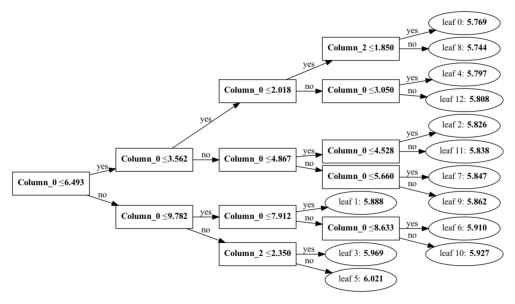

In [55]:
ltb.plot_tree(cv.best_estimator_.named_steps.model)
plt.show()

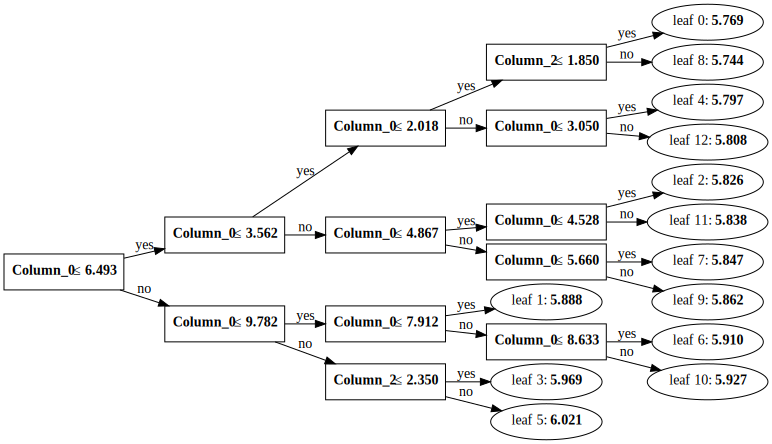

In [56]:
ltb.create_tree_digraph(cv.best_estimator_.named_steps.model)

In [57]:
feature_df = pd.DataFrame({'feature_name': cv.best_estimator_.feature_names_in_,
                           'feature_importance': cv.best_estimator_.named_steps.model.feature_importances_})

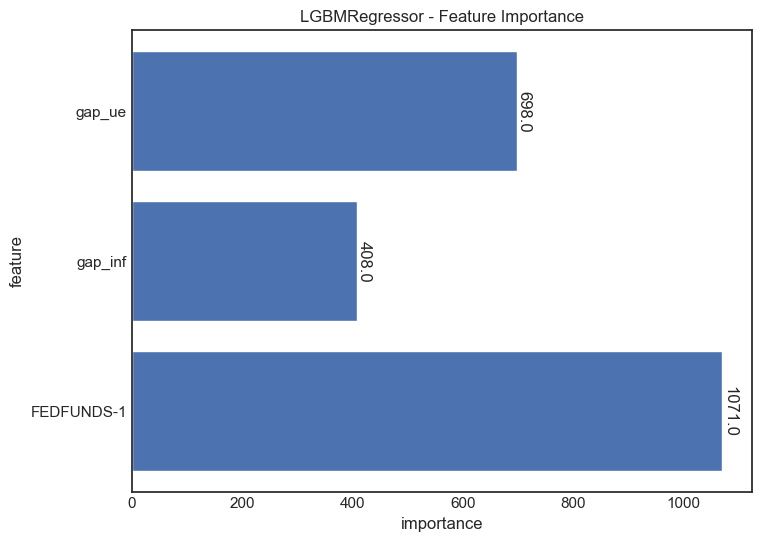

In [58]:
plt.figure(figsize=(8, 6))

bars = plt.barh(feature_df['feature_name'], feature_df['feature_importance'])
    
# Add vertical labels to the bars
for i, value in enumerate(feature_df['feature_importance']):
    plt.text(value, i, f'{value:.1f}', va='center', ha='left', rotation=-90)

    
plt.xlabel('importance')
plt.ylabel('feature')
plt.title('LGBMRegressor - Feature Importance')
plt.grid(False)
plt.show()

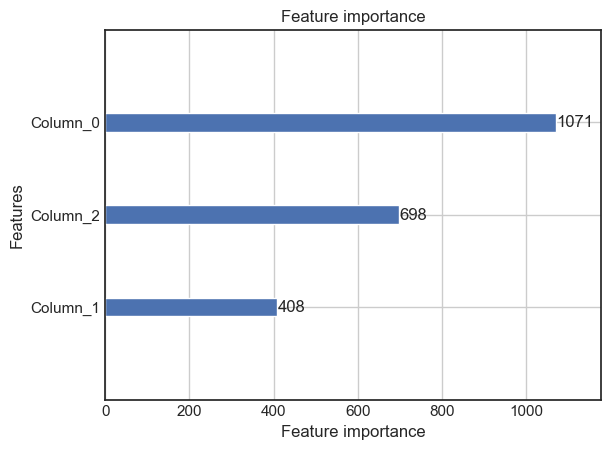

In [59]:
ltb.plot_importance(cv.best_estimator_.named_steps.model)
plt.show()

In [60]:
#model_stats_df = model_results('lgbm_train', y_train, train_pred_lgbm, X_train.shape[0], X_train.shape[1] , model_stats_df )

## Test

In [61]:
test_pred_lgbm = cv.best_estimator_.predict(X_test, pred_contrib=False, raw_score=False)
test_pred_lgbm.shape

(49,)

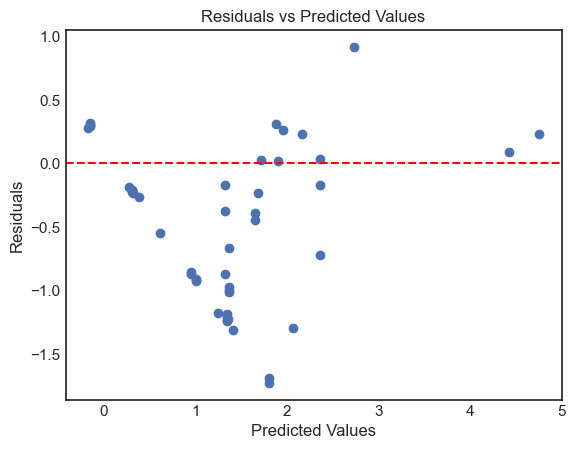

In [62]:
residuals = y_test - test_pred_lgbm
plt.scatter(test_pred_lgbm, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='red', linestyle='--')  # Add horizontal line at y=0 for reference
plt.show()

In [63]:
#model_stats_df = model_results('lgbm_test', y_test, test_pred_lgbm, X_test.shape[0], X_test.shape[1] , model_stats_df )

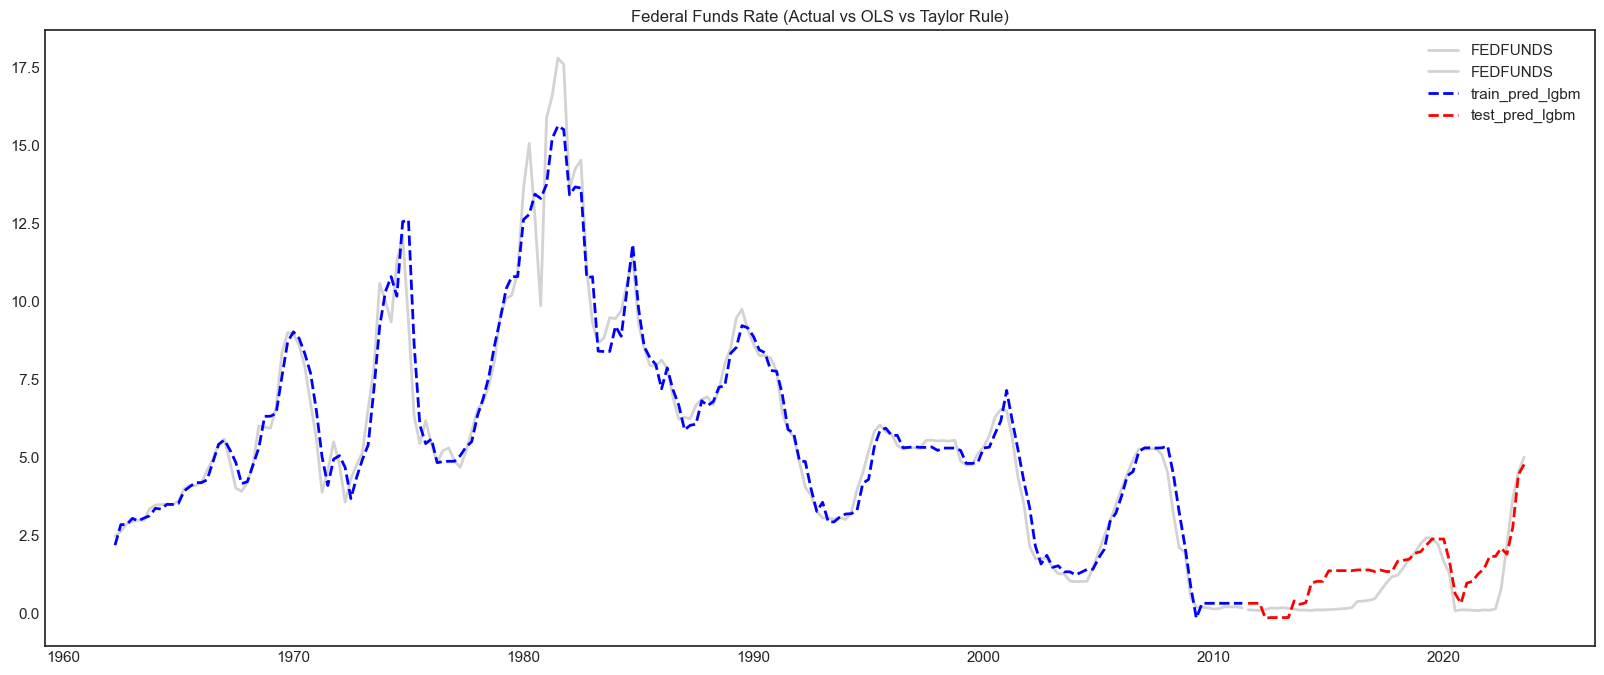

In [64]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(X_train.index, train_pred_lgbm, color='blue', linestyle='--', linewidth=2)
ax.plot(X_test.index, test_pred_lgbm, color='red', linestyle='--', linewidth=2)
#ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_lgbm","test_pred_lgbm"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');
plt.show()

# XGB

In [65]:
pipe_xgb = Pipeline(
    steps = [ ('preprocessor',preprocessor), ('model',xgb.XGBRegressor())]
)

param_xgb = {
    'model__learning_rate': uniform(0.01, 0.5),
    'model__n_estimators': randint(100, 300),
    'model__max_depth': randint(3, 10),
    'model__min_child_weight' : randint(1, 15),
    'model__subsample' : uniform(0.05, 1.0),
    'model__colsample_bytree' : uniform(0.05, 1.0),
    'model__reg_alpha' : uniform(0.01, 0.1), 
    'model__verbose': [-1],
}


cv = RandomizedSearchCV(estimator = pipe_xgb, 
                        param_distributions = param_xgb,
                        random_state=rand_int, 
                        scoring="r2")

cv.fit(X_train, y_train)
cv_results = cv.cv_results_['mean_test_score']
print('XGB', ') Best Accuracy Score:' , cv.best_score_ , 'Parameters: {}' , cv.best_params_)

XGB ) Best Accuracy Score: 0.3383668525332805 Parameters: {} {'model__colsample_bytree': 0.16627301740168982, 'model__learning_rate': 0.16494879224501463, 'model__max_depth': 6, 'model__min_child_weight': 12, 'model__n_estimators': 287, 'model__reg_alpha': 0.09161682980460269, 'model__subsample': 0.33958678353055355, 'model__verbose': -1}


In [66]:
cv.best_estimator_.named_steps.model.score(X_train_trf, y_train)

0.9379141905841959

In [67]:
cv.best_estimator_.named_steps.model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.16627301740168982, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.16494879224501463, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=12, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=287, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [68]:
train_pred_xgb = cv.best_estimator_.predict(X_train)

In [69]:
fig, ax = plt.subplots(figsize=(25,10))
#plt.figure(figsize=(12,12))
#xgb.plot_tree(xgb_model, ax=ax)
xgb.plot_tree(cv.best_estimator_.named_steps.model, ax=ax,fontsize=10)

fig.set_size_inches(150, 100)
fig.savefig('tree.png')

plt.show()

In [70]:
cv

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imp_num',
                                                                                                SimpleImputer())]),
                                                                               ['FEDFUNDS-1',
                                                                                'gap_inf',
                                                                                'gap_ue'])])),
                                             ('model',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           device=None,
                                                           early_stopping_rounds...
                                        'model__min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x28ee8fd60>,
                                        'model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x28ee8f910>,
                                        'model__reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x28f4b1f00>,
                                        'model__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x28f4b2110>,
                                        'model__verbose': [-1]},
                   random_state=12, scoring='r2')

In [71]:
feature_df = pd.DataFrame({'feature_name': cv.best_estimator_.feature_names_in_,
                           'feature_importance': cv.best_estimator_.named_steps.model.feature_importances_})

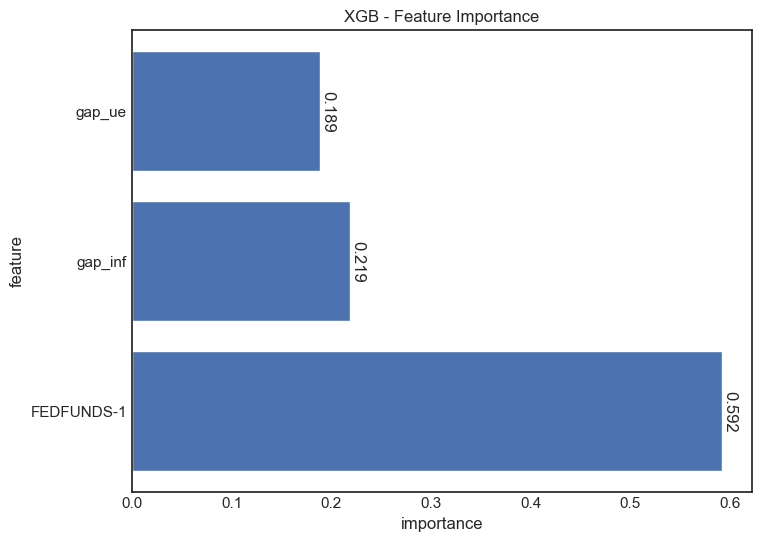

In [72]:
plt.figure(figsize=(8, 6))

bars = plt.barh(feature_df['feature_name'], feature_df['feature_importance'])
    
# Add vertical labels to the bars
for i, value in enumerate(feature_df['feature_importance']):
    plt.text(value, i, f'{value:.3f}', va='center', ha='left', rotation=-90)

    
plt.xlabel('importance')
plt.ylabel('feature')
plt.title('XGB - Feature Importance')
plt.grid(False)
plt.show()

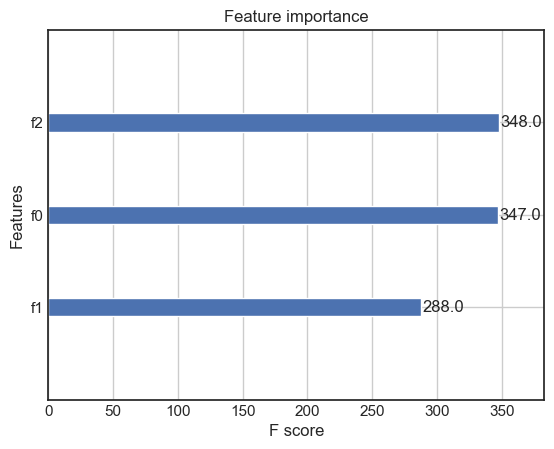

In [73]:
xgb.plot_importance(cv.best_estimator_.named_steps.model)
plt.show()

In [74]:
#model_stats_df = model_results('xgb_train', y_train, train_pred_xgb, X_train.shape[0], X_train.shape[1] , model_stats_df )

## Test

In [75]:
test_pred_xgb = cv.best_estimator_.predict(X_test)
print('test_pred_xbg: ', test_pred_xgb.shape)

test_pred_xbg:  (49,)


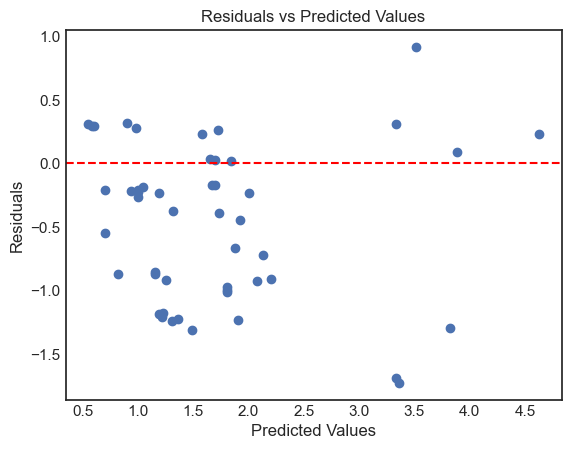

In [76]:
residuals = y_test - test_pred_lgbm
plt.scatter(test_pred_xgb, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='red', linestyle='--')  # Add horizontal line at y=0 for reference
plt.show()

In [77]:
#model_stats_df = model_results('xgb_test', y_test, test_pred_lgbm, X_test.shape[0], X_test.shape[1] , model_stats_df )

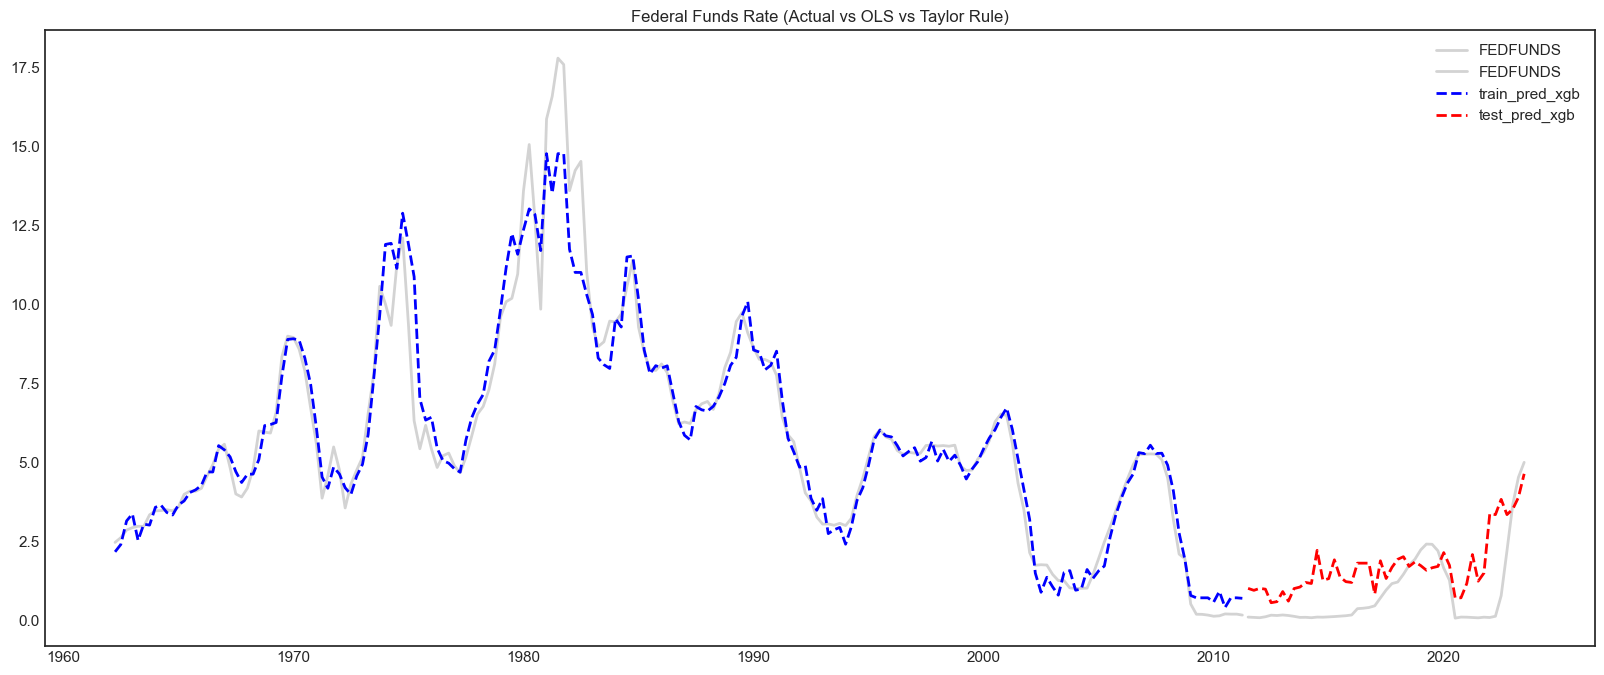

In [78]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(X_train.index, train_pred_xgb, color='blue', linestyle='--', linewidth=2)
ax.plot(X_test.index, test_pred_xgb, color='red', linestyle='--', linewidth=2)
#ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_xgb","test_pred_xgb"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');
plt.show()

# AdaBoostRegressor

In [79]:
pipe_ada = Pipeline(
    steps = [ ('preprocessor',preprocessor), ('model',AdaBoostRegressor())]
)

param_ada = {
    'model__learning_rate' : [0.01, 0.1, 0.5, 1.0],
    'model__n_estimators' : [50, 100, 150, 200, 250],
    'model__loss' : ["linear","exponential"],  
}


cv = RandomizedSearchCV(estimator = pipe_ada, 
                        param_distributions = param_ada,
                        random_state=rand_int, 
                        scoring="r2")

cv.fit(X_train, y_train)
cv_results = cv.cv_results_['mean_test_score']
print('ADA', ') Best Accuracy Score:' , cv.best_score_ , 'Parameters: {}' , cv.best_params_)

ADA ) Best Accuracy Score: 0.5771807310837878 Parameters: {} {'model__n_estimators': 250, 'model__loss': 'exponential', 'model__learning_rate': 0.01}


In [80]:
cv.best_estimator_.named_steps.model.score(X_train_trf, y_train)

0.9458256354739683

In [81]:
cv.best_estimator_.named_steps.model

AdaBoostRegressor(learning_rate=0.01, loss='exponential', n_estimators=250)

In [82]:
feature_df = pd.DataFrame({'feature_name': cv.best_estimator_.feature_names_in_,
                           'feature_importance': cv.best_estimator_.named_steps.model.feature_importances_})

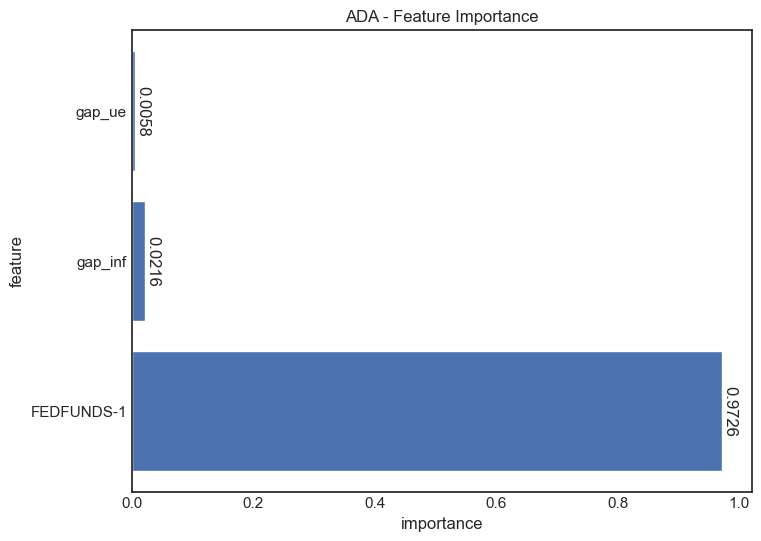

In [83]:
plt.figure(figsize=(8, 6))

bars = plt.barh(feature_df['feature_name'], feature_df['feature_importance'])
    
# Add vertical labels to the bars
for i, value in enumerate(feature_df['feature_importance']):
    plt.text(value, i, f'{value:.4f}', va='center', ha='left', rotation=-90)

    
plt.xlabel('importance')
plt.ylabel('feature')
plt.title('ADA - Feature Importance')
plt.grid(False)
plt.show()

In [84]:
train_pred_ada = cv.best_estimator_.predict(X_train)
#model_stats_df = model_results('ada_test', y_train, train_pred_ada, X_train.shape[0], X_train.shape[1] , model_stats_df )

In [85]:
test_pred_ada = cv.best_estimator_.predict(X_test)
#model_stats_df = model_results('ada_test', y_test, test_pred_ada, X_test.shape[0], X_test.shape[1] , model_stats_df )

# tsa.SARIMAX

In [86]:
sarimax_model = sm.tsa.SARIMAX(y_train, exog=X_train_trf).fit(disp=False)

sarimax_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               FEDFUNDS   No. Observations:                  197
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -262.487
Date:                Sun, 31 Dec 2023   AIC                            534.974
Time:                        18:32:05   BIC                            551.390
Sample:                    03-31-1962   HQIC                           541.619
                         - 03-31-2011                                         
Covariance Type:                  opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
num__FEDFUNDS-1     0.9562      0.031     31.198      0.000       0.896       1.016
num__gap_inf        0.0928      0.035      2.676      0.007       0.025       0.161
num__gap_ue        -0.0894      0.079     -1.125      0.261      -0.245       0.066
ar.L1               0.2283      0.063      3.611      0.000       0.104       0.352
sigma2              0.8408      0.046     18.143      0.000       0.750       0.932
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):              1508.62
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               0.25   Skew:                             0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [87]:
train_result = sarimax_model.get_prediction(start=-len(X_train_trf), dynamic=True)

In [88]:
train_pred_SARIM = train_result.summary_frame()
train_pred_SARIM

FEDFUNDS,mean,mean_se,mean_ci_lower,mean_ci_upper
1962-03-31,2.135525,0.941843,0.289548,3.981503
1962-06-30,2.237037,0.941843,0.391059,4.083014
1962-09-30,2.367697,0.941843,0.521720,4.213675
1962-12-31,2.609292,0.941843,0.763314,4.455269
1963-03-31,2.655128,0.941843,0.809150,4.501105
...,...,...,...,...
2010-03-31,-0.284396,0.941843,-2.130374,1.561582
2010-06-30,-0.307186,0.941843,-2.153163,1.538792
2010-09-30,-0.288205,0.941843,-2.134183,1.557772
2010-12-31,-0.295091,0.941843,-2.141069,1.550887


## Test

In [89]:
s_idx = len(X_train_trf)
e_idx = s_idx + len(X_test_trf) - 1

test_result = sarimax_model.get_prediction(start=s_idx, end=e_idx, exog=X_test_trf, dynamic=True)

In [90]:
test_pred_SARIM = test_result.summary_frame()
test_pred_SARIM.shape

predict_ci = test_result.conf_int(alpha=0.5)
print('predict_ci: ',predict_ci.shape)

predict_ci:  (49, 2)


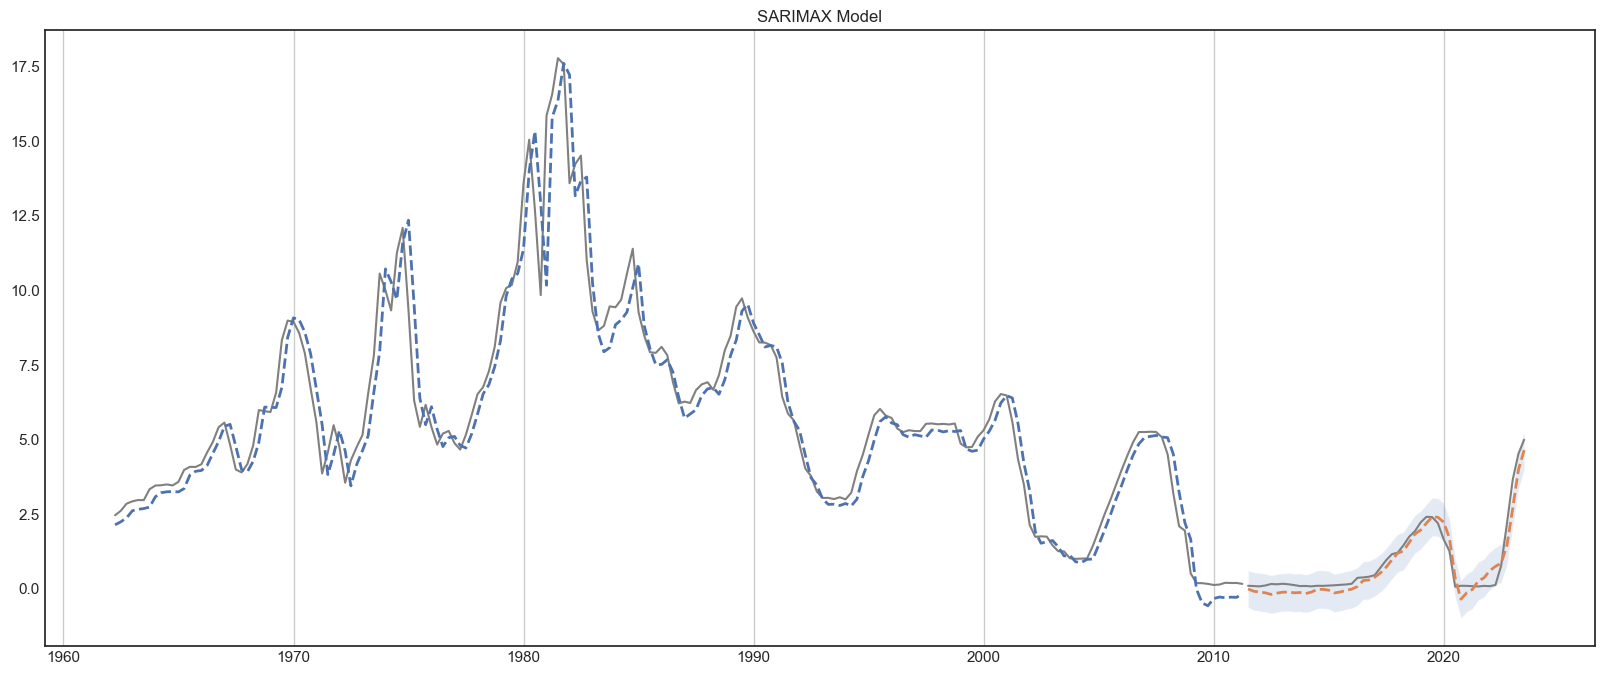

In [91]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'gray')
ax.plot(test_df.index, test_df['FEDFUNDS'], 'gray')
ax.plot(train_pred_SARIM.index, train_pred_SARIM['mean'], linestyle='--', linewidth=2)
ax.plot(test_pred_SARIM.index, test_pred_SARIM['mean'], linestyle='--', linewidth=2)
ax.fill_between(test_pred_SARIM.index, predict_ci['lower FEDFUNDS'], predict_ci['upper FEDFUNDS'], alpha=0.15)

ax.set(title='SARIMAX Model');

plt.show()

In [92]:
#model_stats_df = model_results('SARIMAX_train',train_df['FEDFUNDS'], train_pred_SARIM['mean'], X_train.shape[0],X_test.shape[1] , model_stats_df )
#model_stats_df = model_results('SARIMAX_test', test_df['FEDFUNDS'], test_pred_SARIM['mean'], X_test.shape[0], X_test.shape[1] , model_stats_df )
#model_stats_df